# Import & Load data to memory


In [81]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from music21 import chord, note, stream, clef, meter
from data_cleaning import Open
import os

In [2]:
mid_file1 = os.path.join(os.getcwd(), "progression1.mid")
midi_data1 = Open.open_midi(mid_file1)
mid_file2 = os.path.join(os.getcwd(), "progression2.mid")
midi_data2 = Open.open_midi(mid_file2)

In [3]:
concatenated_array = []

In [5]:
for i, part in enumerate(midi_data2.parts):
    for element in part.recurse():
        if isinstance(element, chord.Chord):
            concatenated_array.append(element)

## Setup useful dictionaries


In [76]:
all_chords = []
for chord in concatenated_array:
    chord_arr = []
    for notes in chord:
        chord_arr.append(notes.pitch.ps)
    all_chords.append(chord_arr)

flattened_list = [int(element)
                  for sublist in all_chords for element in sublist]
notes = sorted(set(flattened_list))
n_to_i = {s: s for i, s in enumerate(notes)}
n_to_i["."] = 128

i_to_n = {}

for n in notes:
    n_temp = note.Note(n)
    i_to_n[n] = n_temp.nameWithOctave

i_to_n[128] = "."

# Designing the Multi Layer Perceptron


## Embeddings


In [7]:
def build_dataset(n_chords):
    block_size = 3
    X, Y = [], []
    for notes in n_chords:
        # print([i_to_n[note] for note in notes])
        # print(notes)
        context = [128] * block_size

        for n in notes + ["."]:
            ix = n_to_i[n]
            X.append(context)
            Y.append(ix)
            # print([i_to_n[note] for note in context])

            context = context[1:] + [ix]
        # print("")

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape)
    print(Y.shape)
    return X, Y

In [8]:
import random

random.seed(42)
random.shuffle(all_chords)
n1 = int(0.8 * len(all_chords))
n2 = int(0.9 * len(all_chords))

Xtr, Ytr = build_dataset(all_chords[:n1])
Xdev, Ydev = build_dataset(all_chords[n1:n2])
Xte, Yte = build_dataset(all_chords[n2:])

torch.Size([786, 3])
torch.Size([786])
torch.Size([99, 3])
torch.Size([99])
torch.Size([106, 3])
torch.Size([106])


# Training


In [9]:
from tqdm import tqdm

## Network


In [66]:
g = torch.Generator().manual_seed(57485)
C = torch.randn((129, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 200), generator=g, requires_grad=True)
b1 = torch.randn(200, generator=g, requires_grad=True)
W2 = torch.randn((200, 129), generator=g, requires_grad=True)
b2 = torch.randn(129, generator=g, requires_grad=True)
parameters = [C, W1, W2, b1, b2]

## Loop


In [65]:
final_loss = []
lri = []
stepsi = []

In [ ]:
for i in tqdm(range(50000), desc=f"Training: {final_loss}", leave=True):
    ix = torch.randint(0, Xtr.shape[0], (129,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad
    stepsi.append(i)
    final_loss.append(loss.log10().item())

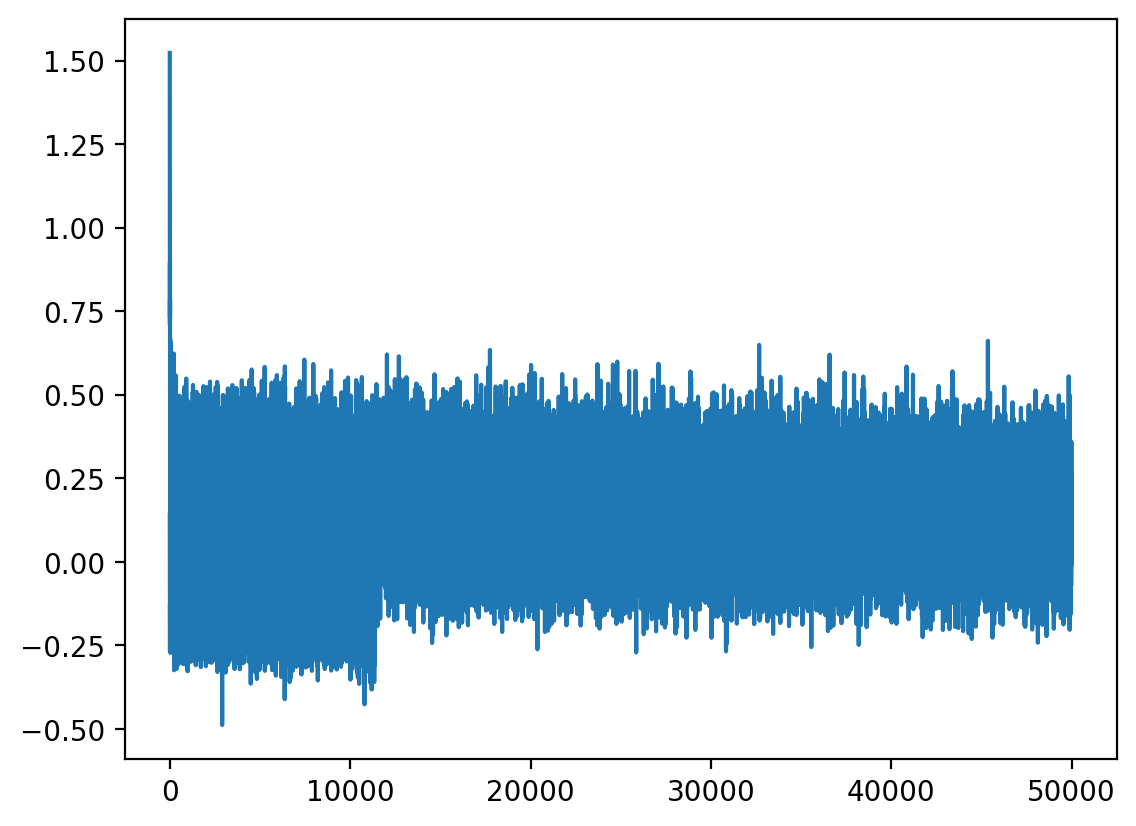

In [71]:
plt.plot(stepsi, final_loss)

## Evaluate Loss (test)


In [72]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

RuntimeError: mat1 and mat2 shapes cannot be multiplied (530x6 and 30x200)

## Evaluate the Loss (dev)


In [46]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.8723, grad_fn=<NllLossBackward0>)

# Visualize


In [51]:
C[0, 0]

tensor(0.7624, grad_fn=<SelectBackward0>)

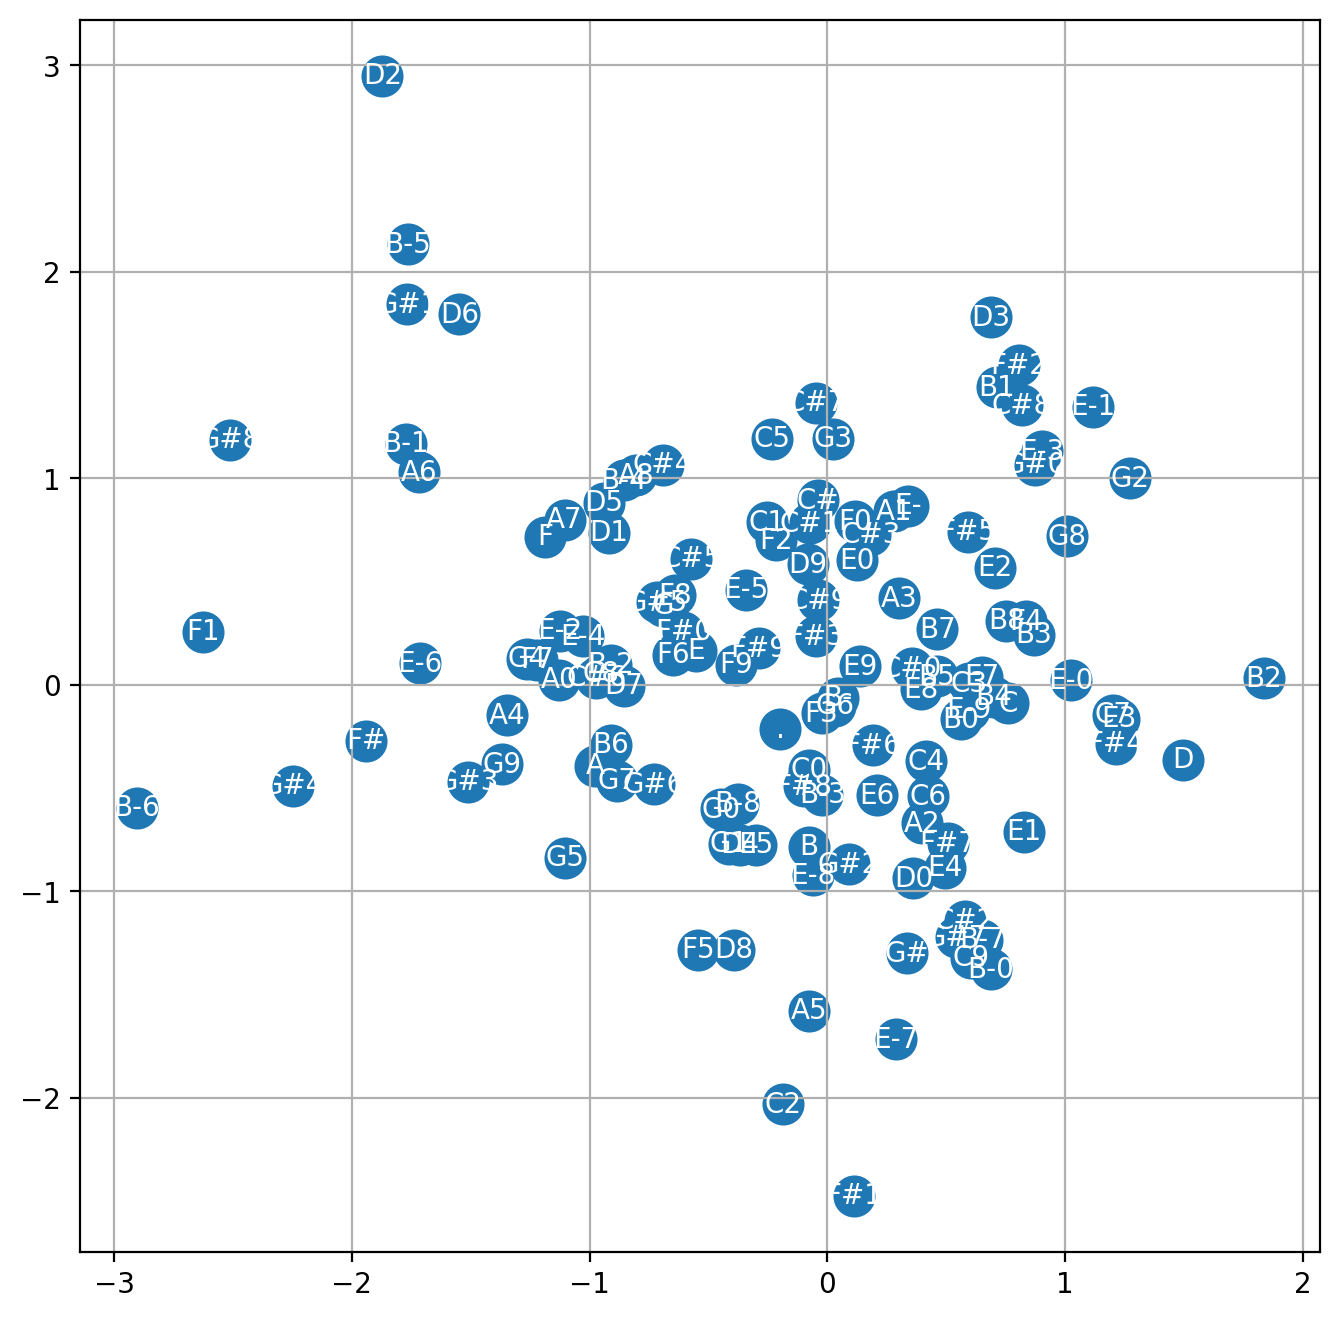

In [53]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), i_to_n[i],
             ha="center", va="center", color="white")
plt.grid('minor')

# Sampling from the model


In [105]:
g = torch.Generator().manual_seed(57485436346)
full_progression = []
for _ in range(8):
    out = []
    context = [0]*3
    while True:
        emb = C[50:80]
        h = torch.tanh(emb.view(10, 30)@W1 + b1)
        print(h.shape, W2.shape)
        logits = h@W2+b2
        print(logits.shape)
        probs = F.softmax(logits, dim=1)
        print(probs.shape)
        ix = torch.multinomial(probs.view(
            129, 10), num_samples=1, generator=g).item()
        context = context[1:]+[ix]

        if ix == 128:
            break
        try:
            out.append(i_to_n[ix])
        except KeyError:
            print("Not in the dictionary, continuing...")
    full_progression.append(out)

torch.Size([10, 200]) torch.Size([200, 129])
torch.Size([10, 129])
torch.Size([10, 129])


RuntimeError: a Tensor with 129 elements cannot be converted to Scalar

In [93]:
C[50:80].view(10, 30)@W1

tensor([[ -5.9833,   1.9113,  -9.1915,  ...,  -5.8059,   0.6353,  -3.2916],
        [  4.9671,  -1.5733,  -2.4464,  ...,  -5.5661,  -6.4294,  -1.7635],
        [  6.9485,  -9.8632,  -4.4869,  ...,   2.5637,  -5.2805,   2.2380],
        ...,
        [  3.6215,   1.3332,   4.3844,  ...,   4.4084,   1.8550,   3.4370],
        [ -7.0160,  -6.2842,  -9.8915,  ..., -14.4474,  -2.4932,  -4.4060],
        [  0.2276,  -8.5035,  -7.4567,  ...,  -2.2167,  -6.2127,  -0.1512]],
       grad_fn=<MmBackward0>)

In [79]:
full_progression

[['C4'],
 ['B4', 'F4', 'B4', 'A2', 'F4', 'A4', 'F4', 'F4', 'G2', 'G3', 'E4'],
 ['D3', 'G3', 'B3'],
 ['B4', 'F4'],
 ['B4', 'A2', 'C5', 'E3', 'B4', 'C4', 'A4'],
 ['G2', 'D3', 'C5', 'D3', 'D4', 'D3', 'C4', 'E3', 'G3', 'C4'],
 ['B4', 'F3', 'E3', 'G3', 'A3', 'C4', 'E4', 'F4'],
 ['D3', 'E4', 'C4']]

In [82]:
s = stream.Score()
for chord_array in full_progression:
    c = chord.Chord(chord_array)
    print(c)
    s.append(c)

<music21.chord.Chord C4>
<music21.chord.Chord B4 F4 B4 A2 F4 A4 F4 F4 G2 G3 E4>
<music21.chord.Chord D3 G3 B3>
<music21.chord.Chord B4 F4>
<music21.chord.Chord B4 A2 C5 E3 B4 C4 A4>
<music21.chord.Chord G2 D3 C5 D3 D4 D3 C4 E3 G3 C4>
<music21.chord.Chord B4 F3 E3 G3 A3 C4 E4 F4>
<music21.chord.Chord D3 E4 C4>


In [83]:
s.write("midi", "output_file.mid")

'output_file.mid'